In [43]:
import numpy as np
import matplotlib.pyplot as plt
from control import dlqr

$$
    \begin{bmatrix}
        v_x \\
        v_y \\
        \omega_z
    \end{bmatrix} 
    =
    \frac{r}{4}
    \begin{bmatrix}
        1 & 1 & 1 & 1 \\
        -1 & 1 & 1 & -1 \\
        -\frac{1}{(l_x + l_y)} & \frac{1}{(l_x + l_y)} & -\frac{1}{(l_x + l_y)} & \frac{1}{(l_x + l_y)}
    \end{bmatrix}
    \begin{bmatrix}
        \dot{\theta}_0 \\
        \dot{\theta}_1 \\
        \dot{\theta}_2 \\
        \dot{\theta}_3
    \end{bmatrix} 
$$

In [44]:
r = 0.0325 # Wheel radius
lx = 0.0845 # Base length x
ly = 0.08 # Base length y

J = (r/4.0)*np.array([[1, 1, 1, 1],
                      [-1, 1, 1, -1],
                      [-1/(lx+ly), 1/(lx+ly), -1/(lx+ly), 1/(lx+ly)]])
J_inv = np.linalg.pinv(J)

### Open Loop

In [45]:
X = np.empty((3,0))
X_dot = np.empty((3,0))
U = np.empty((4,0))

T_s = 0.01
t_f = 10

x = np.array([1, 0.5, np.pi/4]).T
x_dot = np.array([0, 0, 0]).T
u = np.array([1, 1, 1, 1]).T

for t in np.arange(0, t_f, T_s):

    X = np.concatenate([X, x.reshape((-1,1))], axis=1)
    X_dot = np.concatenate([X_dot, x_dot.reshape((-1,1))], axis=1)

    # Rotation marix to transform robot orientation to global frame
    rot_m = np.array([[np.cos(x[2]), -np.sin(x[2]), 0],
                      [np.sin(x[2]), np.cos(x[2]), 0],
                      [0, 0, 1]])
    
    x_dot = np.dot(J, u)

    # Discrete state space
    # x[k-1] = x[k] + J*T_s*u
    x = x + T_s*np.dot(np.dot(rot_m, J), u)


x = 1.2295798941816451
y = 0.7295798941817561
w = 0.7853981633974483


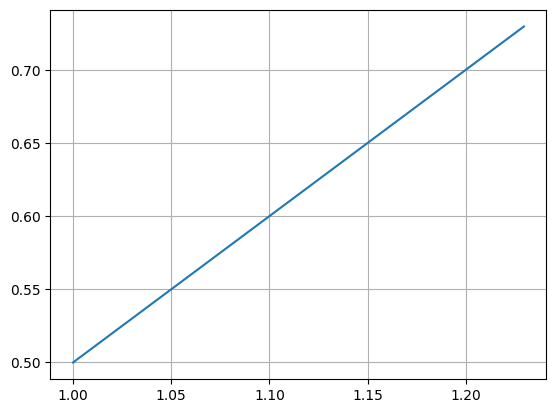

In [46]:
print("x = " + str(X[0,-1]))
print("y = " + str(X[1,-1]))
print("w = " + str(X[2,-1]))

plt.plot(X[0],X[1])
plt.grid()

### Feedback Linearization

In [47]:
X = np.empty((3,0))
U = np.empty((4,0))

T_s = 0.01
t_f = 0.5

x = np.array([0, 0, 0]).T
x_goal = np.array([1, 1, 0]).T

K = np.identity(3)

for t in np.arange(0, t_f, T_s):

    X = np.concatenate([X, x.reshape((-1,1))], axis=1)

    # x_dot = v = J*u = K*(x_goal - x)
    v = np.dot(K, (x_goal - x))

    # Rotation marix to transform robot orientation to global frame
    rot_m = np.array([[np.cos(x[2]), -np.sin(x[2]), 0],
                      [np.sin(x[2]), np.cos(x[2]), 0],
                      [0, 0, 1]])

    # Discrete state space
    # x[k-1] = x[k] + (r/4)*J*T_s*u
    x = x + (T_s/T_s)*np.dot(np.dot(np.dot(rot_m, J), np.linalg.pinv(np.dot(rot_m, J))), v)

x = 1.0
y = 1.0
w = 0.0


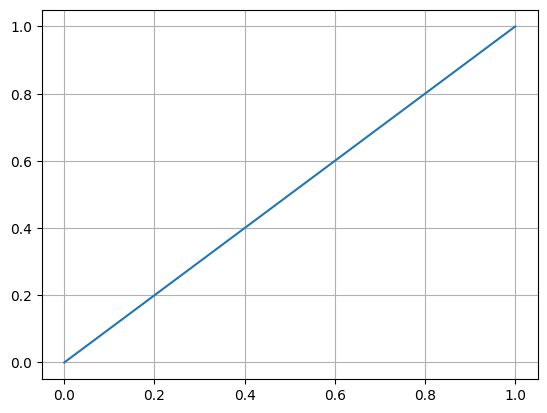

In [48]:
print("x = " + str(X[0,-1]))
print("y = " + str(X[1,-1]))
print("w = " + str(X[2,-1]))

plt.plot(X[0],X[1])
plt.grid()

## Seguimiento de camino

In [49]:
X = np.empty((3,0))
V = np.zeros((3,0))

T_s = 0.01
t_sim = 0

path = np.array([[0,0,0],
                 [1,1,np.pi/2]]).T
# path = np.array([[0, 0, 0],
#                  [1,1,np.pi/4],
#                  [2,1.5,0],
#                  [2.5,1.5,np.pi/2],
#                  [3,3,np.pi]]).T
x = path[:,0]
x_goal = path[:,-1]

#K = np.identity(3)
R = 0.1*np.identity(3)
Q = 0.1*np.identity(3)
K, _, _ = dlqr(np.identity(3),np.identity(3),Q,R)
print("K = " + str(K))

i = 0

distance_to_goal = np.sqrt((x_goal[0] - x[0])**2 + (x_goal[1] - x[1])**2)

while distance_to_goal > 0.01:

    X = np.concatenate([X, x.reshape((-1,1))], axis=1)
    V = np.concatenate([V, v.reshape((-1,1))], axis=1)

    # x_dot = v = J*u = K*(x_goal - x)
    v = np.dot(K, (path[:,i] - x))

    # Rotation marix to transform robot orientation to global frame
    rot_m = np.array([[np.cos(x[2]), -np.sin(x[2]), 0],
                      [np.sin(x[2]), np.cos(x[2]), 0],
                      [0, 0, 1]])
    
    h = np.dot(rot_m, J)

    # Discrete state space
    # x[k-1] = x[k] + T_s*J*u
    x = x + (T_s)*np.dot(np.dot(h, np.linalg.pinv(h)),v)

    distance_to_waypoint = np.sqrt((path[0,i] - x[0])**2 + (path[1,i] - x[1])**2)
    if distance_to_waypoint < 0.01:
        i += 1

    t_sim += T_s
    distance_to_goal = np.sqrt((x_goal[0] - x[0])**2 + (x_goal[1] - x[1])**2)

K = [[0.61803399 0.         0.        ]
 [0.         0.61803399 0.        ]
 [0.         0.         0.61803399]]


In [50]:
t = np.linspace(0,t_sim,np.round(t_sim/T_s).astype(int))

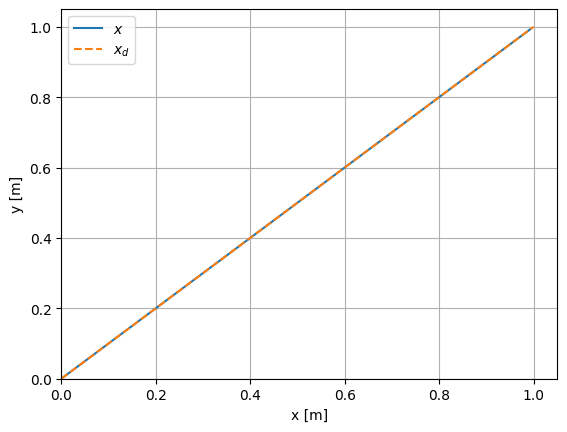

In [51]:
plt.plot(X[0],X[1])
plt.plot(path[0,:],path[1,:],'--')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(0)
plt.ylim(0)
plt.legend([r"$x$", r"$x_d$"])
plt.grid()

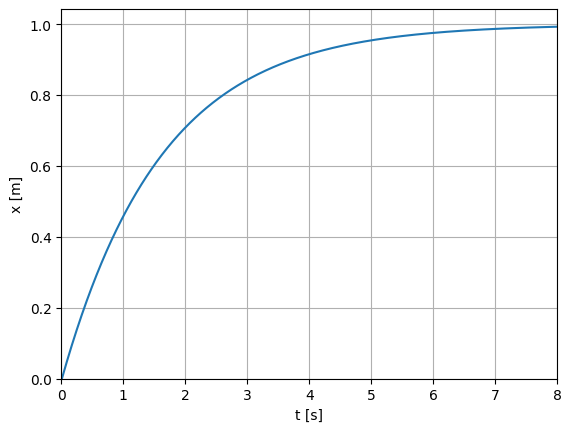

In [52]:
plt.plot(t,X[0])
plt.xlabel("t [s]")
plt.ylabel("x [m]")
plt.xlim(0,t[-1])
plt.ylim(0)
plt.grid()

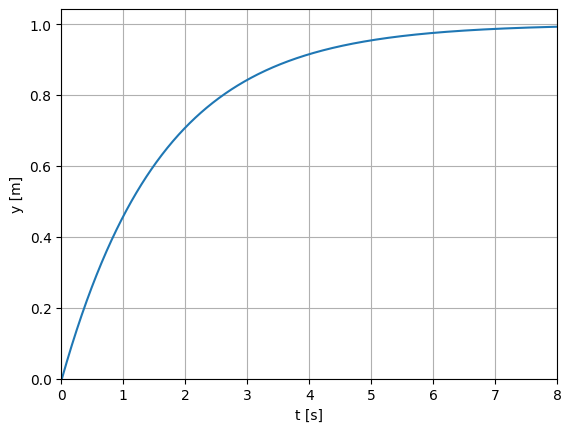

In [53]:
plt.plot(t,X[1])
plt.xlabel("t [s]")
plt.ylabel("y [m]")
plt.xlim(0,t[-1])
plt.ylim(0)
plt.grid()

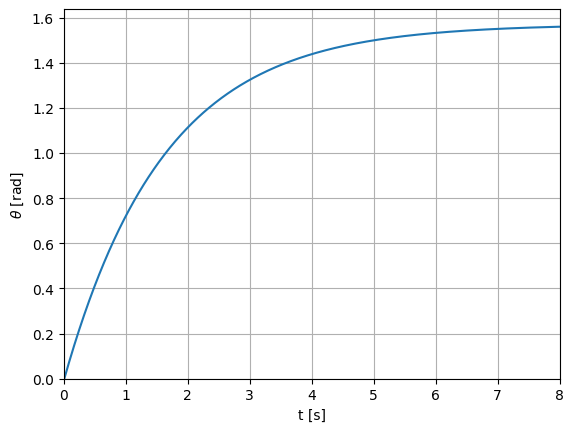

In [54]:
plt.plot(t,X[2])
plt.xlabel("t [s]")
plt.ylabel(r"$\theta$ [rad]")
plt.xlim(0,t[-1])
plt.ylim(0)
plt.grid()

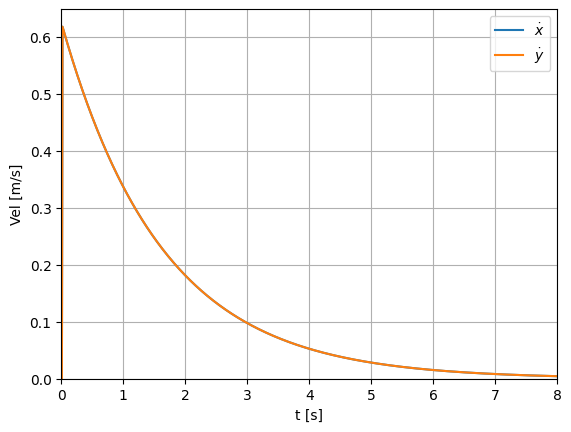

In [55]:
plt.plot(t,V[0],t,V[1])
plt.xlabel("t [s]")
plt.ylabel("Vel [m/s]")
plt.xlim(0,t[-1])
plt.ylim(0)
plt.legend([r"$\dot{x}$", r"$\dot{y}$"])
plt.grid()

In [56]:
# print("x = " + str(X[0,-1]))
# print("y = " + str(X[1,-1]))
# print("w = " + str(X[2,-1]))

# t = np.linspace(0,t_sim,np.round(t_sim/T_s).astype(int))

# plt.figure(figsize=(15,8))

# plt.subplot(2,2,1)
# plt.plot(X[0],X[1])
# plt.plot(path[0,:],path[1,:],'--')
# plt.grid()

# plt.subplot(2,2,2)
# plt.plot(t,X[2])
# plt.grid()

# plt.subplot(2,2,3)
# plt.plot(t,V[0],t,V[1])
# plt.grid()

## Seguimiento de trayectoria

In [57]:
X = np.empty((3,0))
X_d = np.empty((3,0))
V = np.zeros((3,0))

T_s = 0.01
t_sim = 100

x_d = np.array([0,1,0])
x = np.array([0,0,0])

#K = np.identity(3)
R = 0.1*np.identity(3)
Q = 0.1*np.identity(3)
K, _, _ = dlqr(np.identity(3),np.identity(3),Q,R)
print("K = " + str(K))


distance_to_goal = np.sqrt((x_goal[0] - x[0])**2 + (x_goal[1] - x[1])**2)

for i in range(0,int(t_sim/T_s)):

    X = np.concatenate([X, x.reshape((-1,1))], axis=1)
    X_d = np.concatenate([X_d, x_d.reshape((-1,1))], axis=1)
    V = np.concatenate([V, v.reshape((-1,1))], axis=1)

    t = i*T_s
    x_d = np.array([np.sin(0.1*t),np.cos(0.1*t),0]).T

    # x_dot = v = J*u = K*(x_goal - x)
    v = np.dot(K, (x_d - x))

    # Rotation marix to transform robot orientation to global frame
    rot_m = np.array([[np.cos(x[2]), -np.sin(x[2]), 0],
                      [np.sin(x[2]), np.cos(x[2]), 0],
                      [0, 0, 1]])
    
    h = np.dot(rot_m, J)

    # Discrete state space
    # x[k-1] = x[k] + T_s*J*u
    x = x + (T_s)*np.dot(np.dot(h, np.linalg.pinv(h)),v)

K = [[0.61803399 0.         0.        ]
 [0.         0.61803399 0.        ]
 [0.         0.         0.61803399]]


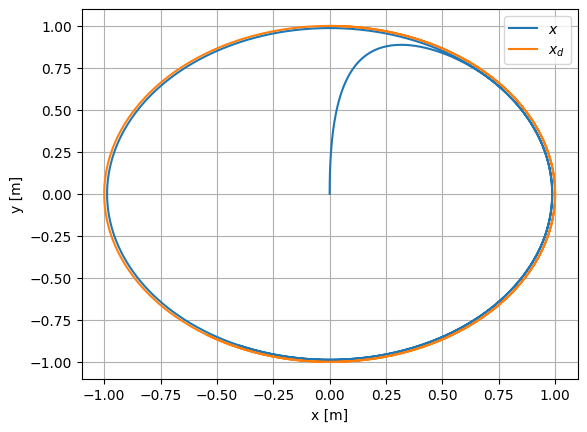

In [58]:
plt.plot(X[0],X[1])
plt.plot(X_d[0],X_d[1])
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend([r"$x$", r"$x_d$"])
plt.grid()

In [59]:
t = np.linspace(0,t_sim,np.round(t_sim/T_s).astype(int))

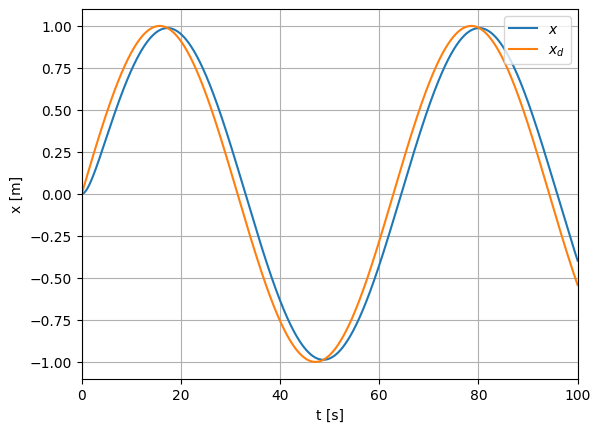

In [60]:
plt.plot(t,X[0],t,X_d[0])
plt.xlabel("t [s]")
plt.ylabel("x [m]")
plt.xlim(0,t[-1])
plt.legend([r"$x$", r"$x_d$"],loc=1)
plt.grid()

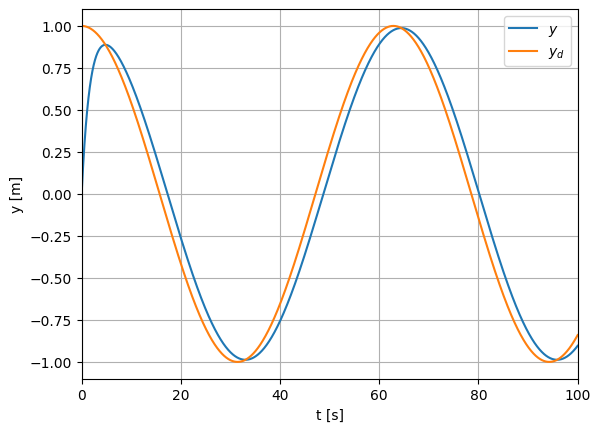

In [61]:
plt.plot(t,X[1],t,X_d[1])
plt.xlabel("t [s]")
plt.ylabel("y [m]")
plt.xlim(0,t[-1])
plt.legend([r"$y$", r"$y_d$"])
plt.grid()

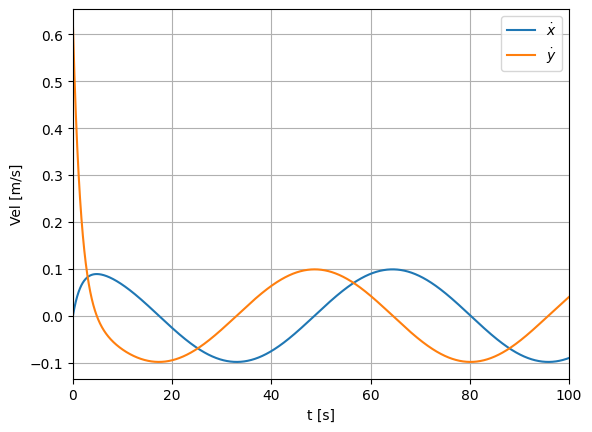

In [62]:
plt.plot(t,V[0],t,V[1])
plt.xlabel("t [s]")
plt.ylabel("Vel [m/s]")
plt.xlim(0,t[-1])
plt.legend([r"$\dot{x}$", r"$\dot{y}$"])
plt.grid()